In [1]:
import pandas as pd
import cptac
import numpy as np
import seaborn as sns
import deva
import scipy
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [162]:
ov = cptac.Ovarian()
clinical = ov.get_clinical()
proteomics = ov.get_proteomics()

In [163]:
follow_up = pd.read_excel('../Follow_Up_Data/Ovary_One_Year_Clinical_Data_20160927.xls')

In [164]:
for col in follow_up.columns:
    if len(follow_up[col].value_counts()) <= 1:
        follow_up = follow_up.drop(col, axis=1)

cols_to_drop = ['Short Title', 'Event', 'Modified Time',
                'Modified By', 'Status', 'CRF Name', 
                'Was a Review of the Initial Pathological Findings Done?', 
                'Was the Pathology Review consistent with the Diagnosis?', 
                'Adjuvant (Post-Operative) Radiation Therapy', 
                'Adjuvant (Post-Operative) Immunotherapy', 
                'Adjuvant (Post-Operative) Hormone Therapy', 
                'Anatomic Site of New Tumor Event', 
                'Other Site of New Tumor Event or Lymph Node Location', 
                'Method Of Diagnosis of New Tumor Event', 
                'Date of Additional Surgery for New Tumor Event', 
                'Additional Hormone Therapy Treatment of New Tumor Event', 
                'Additional Targeted Molecular Therapy Treatment of New Tumor Event', 
                'What Type of Malignancy was This?', 'Primary Site of Disease', 
                'Laterality of the Disease', 'Did the patient have surgery for this malignancy?',
                'Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to the Date of Initial Diagnosis of Other Malignancy', 
                'Did the patient receive pharmaceutical therapy for this malignancy?', 
                'Was the patient staged using FIGO?', ' Was the patient staged using AJCC?']

follow_up = follow_up.drop(cols_to_drop, axis=1).copy()

In [165]:
#Replace variations of NaN with one consistent value
things_to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown', 
                     'Not Reported/Unknown' 'Not Applicable', 
                     'na','unknown', 'Not Performed', 
                     'Unknown tumor status', 'Unknown']

follow_up = follow_up.replace(things_to_replace, np.nan)
clinical = clinical.replace(things_to_replace, np.nan)

chemo_to_replace = ['Chemotherapy', 'Chemo', 'chemotherapy']
phase_to_replace = ['Phase I', 'Phase 1', 'Pahse I', 'With other Phase I drug']
inhibitors_to_replace = ['PARP Inhibitor', 'aromatase inhibitor']
other_to_replace = ['alkylating agent', 'plant alkaloid', 
                    'monoclonal antibody', 'GOG9923']

col = 'Clinical Trial Drug Classification'

follow_up[col] = follow_up[col].replace(chemo_to_replace, 'Chemotherapy')
follow_up[col] = follow_up[col].replace(phase_to_replace, 'Phase I')
follow_up[col] = follow_up[col].replace(inhibitors_to_replace, 'Inhibitors')
follow_up[col] = follow_up[col].replace(other_to_replace, 'Other')

In [166]:
follow_up = follow_up.rename({'PPID': 'Patient_ID'}, axis='columns')

In [167]:
focus_group = pd.merge(clinical, follow_up, on = "Patient_ID")

In [266]:
cols = list(clinical.columns)
omics_genes = ['GBP2', 'GBP5', 'RAC2', 'PODXL']
# omics_genes=["GBP2", "GBP5", "RAC2",
#              'ABCC1','ALDH3A1',
#              'ANXA9','BCKDHB',
#              'CDH2','DNAJC19',
#              'FHIT','FUS',
#              'GCDH','HIBCH',
#              'IMPDH2','ISCA2',
#              'KNOP1','NIPSNAP2',
#              'PFKM','PODXL',
#              'SALL2','SAMM50',
#              'SKP1','SLC39A10',
#              'TBC1D10B','TBC1D24',
#              'TKT','TOMM40L','TSN']

# omics_genes = ['RAC2','CDH2','IMPDH2','ISCA2',
#                'PFKM','PODXL','SAMM50','TKT']

# omics_genes = ['PODXL', 'PFKM', 'CDH2', 'RAC2']
df_test = ov.join_metadata_to_omics(metadata_df_name="clinical", 
                                    omics_df_name="proteomics", 
                                    metadata_cols=cols, 
                                    omics_genes=omics_genes)
df_test = ov.reduce_multiindex(df_test, levels_to_drop="Database_ID")

focus_group = pd.merge(df_test, follow_up, on = "Patient_ID")

In [267]:
for i in range(len(omics_genes)):
    omics_genes[i] += "_proteomics"

In [268]:
cols = ['New_Tumor_Event_After_Initial_Treatment', 'Tumor_Status']
for col in cols:
    focus_group[col] = focus_group[col].replace("Not Reported/Unknown", np.nan)
    focus_group[col] = focus_group[col].replace("Not Applicable", np.nan)

In [269]:
cols_to_focus_on = ["Patient_ID", "Participant_Race", 
                    "Origin_Site_Disease", "Tumor_Stage_Ovary_FIGO", 
                    "Days_Between_Collection_And_Last_Contact", 
                    "Vital_Status", "Days_Between_Collection_And_Death", 
                    "Tumor_Status", "New_Tumor_Event_After_Initial_Treatment", 
                    "Days_Between_Collection_And_New_Tumor_Event"]

for gene in omics_genes:
    cols_to_focus_on.append(gene)

focus_group = focus_group[cols_to_focus_on]

In [270]:
figo_map = {"IIIC" : 3, "IIIB" : 3, 
            "Not Reported/ Unknown" : np.nan, 
            "IIIA" : 3, "III" : 3, 
            "IC" : 1, "IV" : 4}
focus_group['Tumor_Stage_Ovary_FIGO'] = focus_group['Tumor_Stage_Ovary_FIGO'].map(figo_map)

In [271]:
focus_group.index = focus_group['Patient_ID']

In [272]:
cols = ['Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']

focus_group = focus_group.assign(Days_Until_Last_Contact_Or_Death=focus_group[cols].sum(1)).drop(cols, 1)

In [273]:
cols = ["Tumor_Stage_Ovary_FIGO",
        "Vital_Status", 
        "Days_Until_Last_Contact_Or_Death"]

for gene in omics_genes:
    cols.append(gene)

focus_group = focus_group[cols].dropna().copy()

In [274]:
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Living', False)
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Deceased', True)

In [275]:
focus_group['Vital_Status'].value_counts()

False    209
True      25
Name: Vital_Status, dtype: int64

In [276]:
focus_group.columns

Index(['Tumor_Stage_Ovary_FIGO', 'Vital_Status',
       'Days_Until_Last_Contact_Or_Death', 'GBP2_proteomics',
       'GBP5_proteomics', 'RAC2_proteomics', 'PODXL_proteomics'],
      dtype='object')

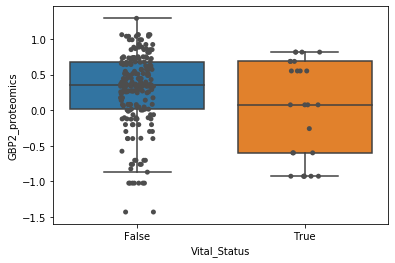

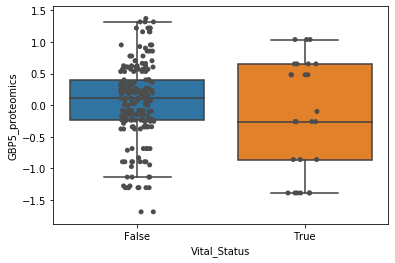

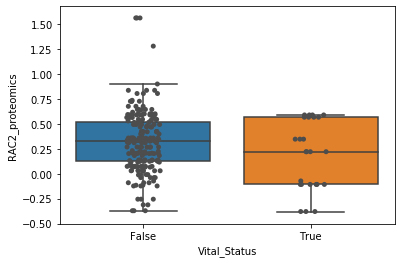

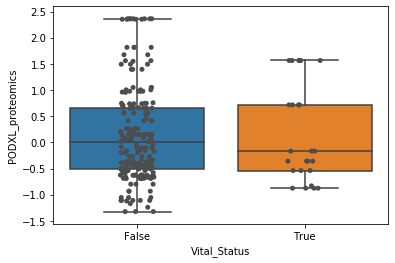

In [277]:
#Plots
#data_cols = ["GBP2_proteomics", "RAC2_proteomics", "GBP5_proteomics"]
for gene in omics_genes:
    sns.boxplot(x="Vital_Status", y=gene, 
                data=focus_group, showfliers=False)
    sns.stripplot(x="Vital_Status", y=gene, 
                  data=focus_group, color='0.3')
    plt.show()

In [278]:
df_clean = focus_group.dropna(axis=0, how='any')
deceased = df_clean[df_clean["Vital_Status"] == True]
living = df_clean[df_clean["Vital_Status"] == False]
#living
for gene in omics_genes:
    print(gene)
    print(scipy.stats.ttest_ind(deceased[gene], living[gene]), '\n')

GBP2_proteomics
Ttest_indResult(statistic=-2.3575298439440258, pvalue=0.01922848633577518) 

GBP5_proteomics
Ttest_indResult(statistic=-1.5758380657856301, pvalue=0.11642573399202079) 

RAC2_proteomics
Ttest_indResult(statistic=-2.0253824498167767, pvalue=0.04397327366808724) 

PODXL_proteomics
Ttest_indResult(statistic=0.23436562003656392, pvalue=0.8149078446732387) 



In [279]:
df_genes = df_clean.copy()
for col in omics_genes:
    lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)
    upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)

    df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])
    df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])
    df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])

In [280]:
time = df_genes['Days_Until_Last_Contact_Or_Death']
status = df_genes['Vital_Status']

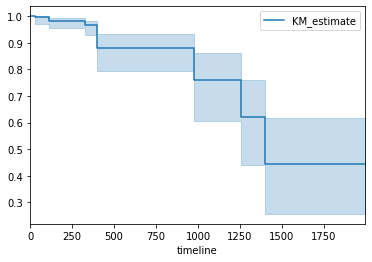

In [281]:
kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

In [282]:
proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
for gene in omics_genes:
    df_genes[gene] = df_genes[gene].map(proteomics_map)

In [283]:
df_genes.columns

Index(['Tumor_Stage_Ovary_FIGO', 'Vital_Status',
       'Days_Until_Last_Contact_Or_Death', 'GBP2_proteomics',
       'GBP5_proteomics', 'RAC2_proteomics', 'PODXL_proteomics'],
      dtype='object')

# For protein expression values, 1 = Lower 25%, 2 = Middle 50%, 3 = Upper 50%

# At first I thought that this can't possibly be right, however, maybe we are on to something here with RAC2 and Tumor Stage

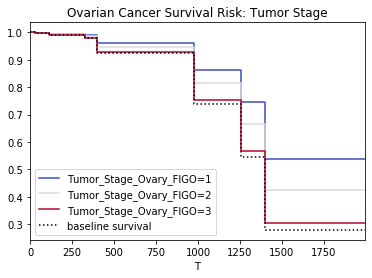

In [284]:
duration = "Days_Until_Last_Contact_Or_Death"
event = "Vital_Status"
cph = CoxPHFitter()
cph.fit(df_genes, duration_col = duration, event_col = event)
cph.plot_covariate_groups('Tumor_Stage_Ovary_FIGO', [1,2,3], cmap='coolwarm', 
                          title= "Ovarian Cancer Survival Risk: Tumor Stage")

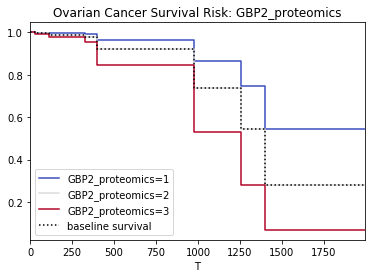

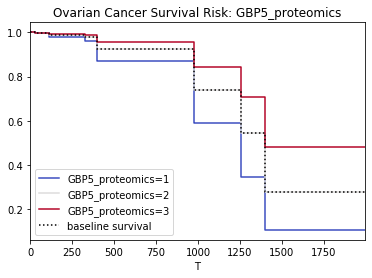

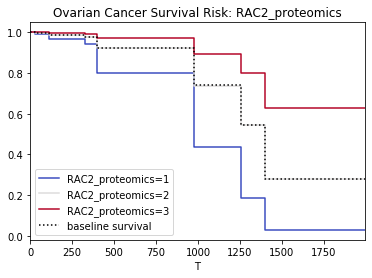

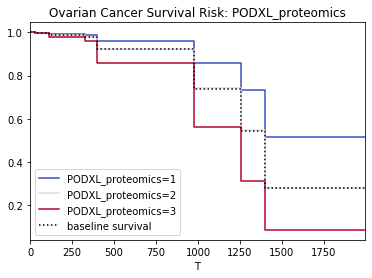

In [285]:
for gene in omics_genes:
    cph.plot_covariate_groups(gene, [1,2,3], cmap='coolwarm', 
                              title= "Ovarian Cancer Survival Risk: "+gene)

In [286]:
df_genes[df_genes['RAC2_proteomics'] == 1]['Vital_Status'].value_counts()

False    49
True     10
Name: Vital_Status, dtype: int64

In [287]:
df_genes[df_genes['Days_Until_Last_Contact_Or_Death'] > 1300]['Vital_Status'].value_counts()

False    14
True      4
Name: Vital_Status, dtype: int64

In [288]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 234 total observations, 209 right-censored observations>
      duration col = 'Days_Until_Last_Contact_Or_Death'
         event col = 'Vital_Status'
number of observations = 234.0
number of events observed = 25.0
partial log-likelihood = -91.909
  time fit was run = 2020-01-09 17:31:03 UTC
             model = untransformed variables


---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Tumor_Stage_Ovary_FIGO  0.327     1.386     0.444          -0.543           1.196               0.581               3.308
GBP2_proteomics         0.742     2.099     0.453          -0.145           1.628               0.865               5.096
GBP5_proteomics        -0.562     0.570     0.426          -1.397           0.274               0.247               1.315
RAC2_proteomics        -1.009     0.365     0.490          -1.969          -0.048               0.140               0.953
PODXL_proteo

In [289]:
results = proportional_hazard_test(cph, df_genes, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                        test_statistic       p  -log2(p)
GBP2_proteomics                  0.251   0.617     0.697
GBP5_proteomics                  0.618   0.432     1.212
PODXL_proteomics                13.328 <0.0005    11.901
RAC2_proteomics                  5.418   0.020     5.649
Tumor_Stage_Ovary_FIGO           6.845   0.009     6.814


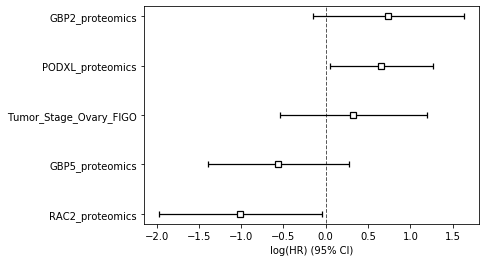

In [290]:
cph.plot()